# Import necessary libraries and python files

Import Necessary Libraries

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [185]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [186]:
from torch.nn import Linear, Dropout, BatchNorm1d, LayerNorm, MultiheadAttention, TransformerEncoderLayer
from torch.optim.optimizer import Optimizer

In [187]:
import joblib

Ensure torch is connected to GPU

In [188]:
# Check if MPS is available and set the device to MPS, else fall back to CUDA or CPU
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print()

Using device: mps



In [189]:
# Install the ipynb library
# !pip install import-ipynb
import import_ipynb

In [190]:
# from google.colab import drive
# drive.mount('/content/drive')

In [191]:
import import_ipynb
from dataset_prep import *
from Transformer_loss_activation_and_optimizer_functions import *
from kMeans_Clustering_Model import *
from Encoder_Transformer_Layers import *

# Plotting helper functions

Plots the training and validation losses.

In [192]:
# Helper function that plots, saves and shows plots
def plot_loss_accuracy(filename, train_losses, test_losses):
  loss = train_losses
  val_loss = test_losses

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')

  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.grid(True)
  plt.legend(loc=0)
  plt.title('Training and validation loss')
  plt.tight_layout()
  plt.figure()

  plt.savefig(filename + '.png')
  plt.show()

# Data Prep

Load data

In [193]:
dataset_id = 1

In [194]:
# Create headers
index_col_names=['unit number','cycle']
operat_set_col_names=['op_conditions_{}'.format(i) for i in range(1,4)]
sensor_measure_col_names=['sensor measurement {}'.format(i) for i in range(1,22)]
all_col=index_col_names+operat_set_col_names+sensor_measure_col_names
print(all_col)

['unit number', 'cycle', 'op_conditions_1', 'op_conditions_2', 'op_conditions_3', 'sensor measurement 1', 'sensor measurement 2', 'sensor measurement 3', 'sensor measurement 4', 'sensor measurement 5', 'sensor measurement 6', 'sensor measurement 7', 'sensor measurement 8', 'sensor measurement 9', 'sensor measurement 10', 'sensor measurement 11', 'sensor measurement 12', 'sensor measurement 13', 'sensor measurement 14', 'sensor measurement 15', 'sensor measurement 16', 'sensor measurement 17', 'sensor measurement 18', 'sensor measurement 19', 'sensor measurement 20', 'sensor measurement 21']


In [195]:
# Import Data - NASA dataset 260 train trajectories, 259 tests and 6 conditions
raw_train_df=pd.read_csv(f'Data/train_FD00{dataset_id}.txt',delim_whitespace=True,names=all_col)
raw_train_df.head()

/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_32500/2948641856.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  raw_train_df=pd.read_csv(f'Data/train_FD00{dataset_id}.txt',delim_whitespace=True,names=all_col)


,unit number,cycle,op_conditions_1,op_conditions_2,op_conditions_3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [196]:
raw_train_df.shape

(20631, 26)

Add RUL Column to dataframe

In [197]:
def RULCol(df):
  max_cycles_df = df.groupby('unit number').max()['cycle'].reset_index().rename(columns={'cycle':'Maxcycle'})
  df = pd.merge(df, max_cycles_df, how='inner', on='unit number')
  df['RUL'] = df['Maxcycle'] - df['cycle']
  return df

In [198]:
raw_train_df = RULCol(raw_train_df)
raw_train_df.head()

,unit number,cycle,op_conditions_1,op_conditions_2,op_conditions_3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21,Maxcycle,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


Global Variables

*   T = constant window length when using sliding window
*   max_len = length of the longest ensemble in the training dataset, declare this when using the expanding window method.

*   Note: If max_len is greater than 512, then it has to be truncated because the encoder-transformer architecture can only take input sequences up to 512 tokens in length.


*  Data preparation methods when using sliding window (i.e max_len = T) is different from when expanding window method is adopted.








In [199]:
min_len = 5
T = 25
max_len = pd.unique(raw_train_df['Maxcycle']).max()
# max_len = T

Plots before normalization

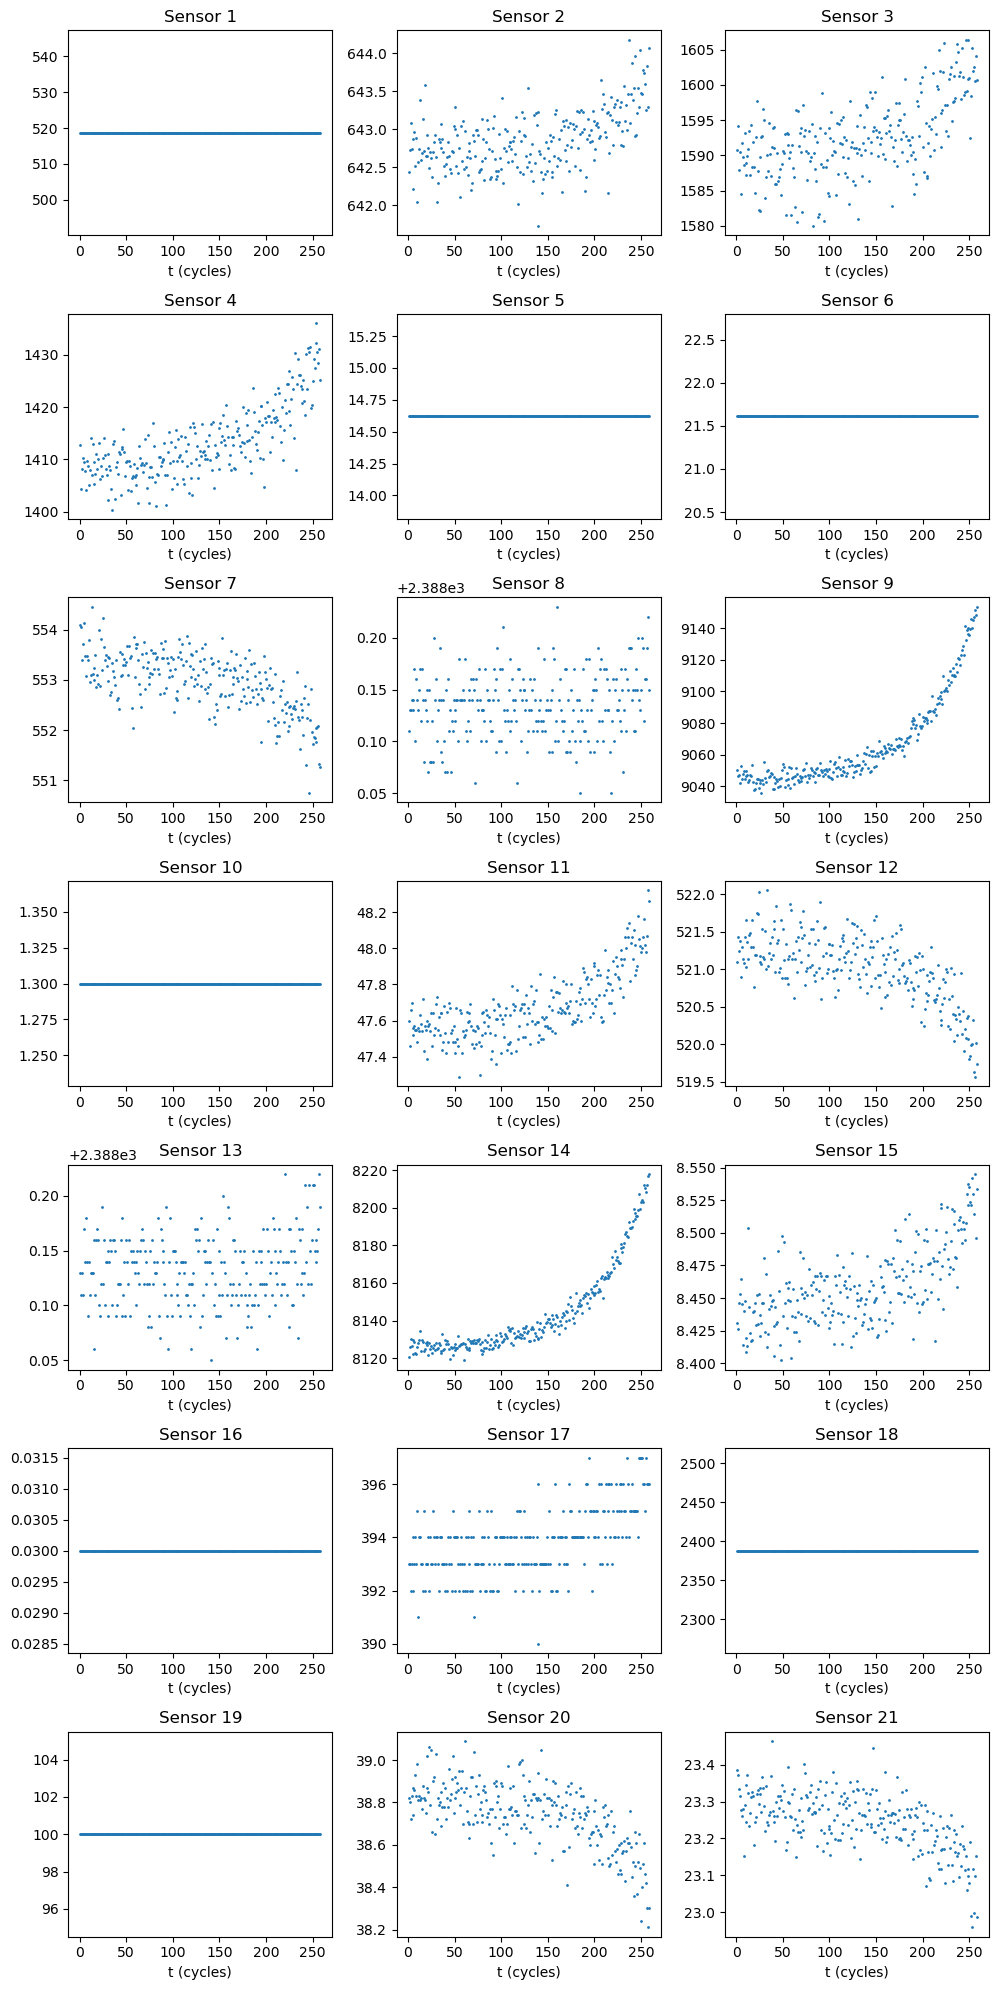

In [200]:
# Let's plot again  (Call split and Plot functions)
engine_id = 94
sensor_ids = range(1, 22)
plot_all_sensors(raw_train_df, engine_id, sensor_ids)

Train - Val Split (Random)

In [201]:
# Args
  # Ensemble data: Dataframe of all run-to-failure data from a fleet of engines
# Returns:
  # Train and validation sets
  # Unit IDs of the machines in the train and val sets
train_df, val_df, test_df, ytest_df, train_id, val_id, test_id = train_val_test_split(df=raw_train_df, val_percent=0.2, test_percent=0.1, seed=42)
print(f'shape test set: {test_df.shape}, shape validation set: {val_df.shape}, shape train set; {train_df.shape}')
print(f'engines used in the train set: {train_id}')
print(f'engines used in the validation set: {val_id}')
print(f'engines used in the test set: {test_id}')

# Check
val_df.shape[0] + train_df.shape[0] + test_df.shape[0] == raw_train_df.shape[0]
test_df.head()

<string>:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


shape test set: (37663, 28), shape validation set: (4241, 28), shape train set; (14203, 28)
engines used in the train set: [  1   2   3   4   5   7  10  11  12  14  16  17  19  20  21  22  23  24
  25  26  27  28  29  30  32  33  34  35  36  38  39  41  42  43  44  45
  47  49  51  52  54  56  57  58  59  60  63  65  68  70  71  73  75  77
  78  79  80  81  82  83  86  88  91  92  93  96  97  98  99 100]
engines used in the validation set: [64 95 18 90 84 72 13  8 55 50 85 87 46 74  9 69 76 37 62 48]
engines used in the test set: [31 61 66 53  6 89 67 15 94 40]


,unit number,cycle,op_conditions_1,op_conditions_2,op_conditions_3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21,Maxcycle,RUL
0,1,1,-0.0009,-0.0000,100.0,518.67,642.32,1582.38,1393.03,14.62,...,8138.73,8.4135,0.03,392,2388,100.0,39.02,23.4287,234,233
1,1,2,-0.0005,-0.0003,100.0,518.67,642.49,1584.07,1394.01,14.62,...,8140.24,8.3995,0.03,393,2388,100.0,39.01,23.4805,234,232
2,1,3,0.0029,-0.0002,100.0,518.67,642.49,1585.07,1394.99,14.62,...,8140.79,8.4159,0.03,391,2388,100.0,39.05,23.3977,234,231
3,1,4,-0.0037,-0.0002,100.0,518.67,642.21,1572.40,1394.07,14.62,...,8136.16,8.4232,0.03,391,2388,100.0,39.02,23.3805,234,230
4,1,5,-0.0011,0.0005,100.0,518.67,641.84,1584.77,1396.82,14.62,...,8139.68,8.3922,0.03,393,2388,100.0,39.11,23.3663,234,229


Features and targets

In [202]:
ytrain_df = train_df.pop('RUL')
yval_df = val_df.pop('RUL')
_ = test_df.pop('RUL')
print(train_df.shape, ytrain_df.shape, val_df.shape, yval_df.shape)

(14203, 27) (14203,) (4241, 27) (4241,)


In [203]:
train_df.drop(columns=['Maxcycle'], inplace=True)
val_df.drop(columns=['Maxcycle'], inplace=True)
test_df.drop(columns=['Maxcycle'], inplace=True)

/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_32500/1894325112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['Maxcycle'], inplace=True)
/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_32500/1894325112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.drop(columns=['Maxcycle'], inplace=True)


# Normalization

Normalize data

In [204]:
# NOTE: Normalize data before the preparation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_df.iloc[:,5:])
traindf_scaled = scaler.transform(train_df.iloc[:,5:])
# Print the mean and standard deviation
print("Means (mu):", scaler.mean_)
print("Standard Deviations (sigma):", scaler.scale_)

Means (mu): [5.18670000e+02 6.42674991e+02 1.59043603e+03 1.40878598e+03
 1.46200000e+01 2.16098000e+01 5.53387284e+02 2.38809425e+03
 9.06580343e+03 1.30000000e+00 4.75362353e+01 5.21428941e+02
 2.38809366e+03 8.14432023e+03 8.44158090e+00 3.00000000e-02
 3.93199606e+02 2.38800000e+03 1.00000000e+02 3.88185834e+01
 2.32915157e+01]
Standard Deviations (sigma): [1.00000000e+00 5.01911650e-01 6.15811639e+00 9.03692126e+00
 1.00000000e+00 1.39985515e-03 8.85047173e-01 6.99632459e-02
 2.17572957e+01 1.00000000e+00 2.67614126e-01 7.36862275e-01
 7.05190838e-02 1.86480487e+01 3.75841399e-02 1.00000000e+00
 1.56010599e+00 1.00000000e+00 1.00000000e+00 1.81236240e-01
 1.08654171e-01]


In [205]:
X_train_df = pd.concat([train_df.iloc[:,:5], traindf_scaled], axis=1)
X_train_df.head()

,unit number,cycle,op_conditions_1,op_conditions_2,op_conditions_3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,-0.0007,-0.0004,100.0,0.0,-1.703470,-0.119522,-0.905837,-3.552714e-15,...,0.313571,-1.044507,-0.305674,-0.587506,-1.040834e-17,-0.768926,0.0,0.0,1.332055,1.173304
1,1,2,0.0019,-0.0003,100.0,0.0,-1.045983,0.224739,-0.624768,-3.552714e-15,...,1.154977,-0.335479,-0.688020,-0.260240,-1.040834e-17,-0.768926,0.0,0.0,1.000995,1.215640
2,1,3,-0.0043,0.0003,100.0,0.0,-0.647507,-0.397205,-0.507471,-3.552714e-15,...,1.344972,-0.902701,-0.594712,-0.632738,-1.040834e-17,-2.050890,0.0,0.0,0.725112,0.484881
3,1,4,0.0007,0.0000,100.0,0.0,-0.647507,-1.241619,-0.765303,-3.552714e-15,...,1.942098,-0.193674,-0.562537,-1.952443,-1.040834e-17,-0.768926,0.0,0.0,0.338876,0.758225
4,1,5,-0.0019,-0.0002,100.0,0.0,-0.607659,-1.231875,-0.283944,-3.552714e-15,...,1.032837,-0.760896,-0.564146,-0.324097,-1.040834e-17,-0.127944,0.0,0.0,0.449229,1.038932


Transform/Scale validation data

In [206]:
valdf_scaled = scaler.transform(val_df.iloc[:,5:])
X_val_df = pd.concat([val_df.iloc[:,:5], valdf_scaled], axis=1)
X_val_df.head()

,unit number,cycle,op_conditions_1,op_conditions_2,op_conditions_3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
1563,8,1,-0.0026,-0.0003,100.0,0.0,1.006171,-0.855137,0.106676,-3.552714e-15,...,-0.269984,0.515354,-1.118092,1.043501,-1.040834e-17,-0.127944,0.0,0.0,0.449229,0.508810
1564,8,2,-0.0012,-0.0003,100.0,0.0,0.488151,-0.725227,0.223972,-3.552714e-15,...,0.530708,0.515354,-1.294518,-0.550256,-1.040834e-17,-0.768926,0.0,0.0,0.449229,0.009980
1565,8,3,0.0001,0.0002,100.0,0.0,0.129522,0.109444,-0.608169,-3.552714e-15,...,0.123577,0.373549,-1.181369,0.216025,-1.040834e-17,-0.127944,0.0,0.0,0.338876,-1.015292
1566,8,4,-0.0021,0.0005,100.0,0.0,0.169370,0.289694,-0.296116,-3.552714e-15,...,-0.242842,0.373549,-1.100395,-0.028759,-1.040834e-17,-0.127944,0.0,0.0,0.228523,-0.500815
1567,8,5,-0.0044,0.0003,100.0,0.0,0.906552,0.921380,0.061306,-3.552714e-15,...,0.096434,0.798966,-1.403376,-1.029181,-1.040834e-17,-0.768926,0.0,0.0,0.338876,0.055077


Transform/Scale test data

In [207]:
testdf_scaled = scaler.transform(test_df.iloc[:,5:])
X_test_df = pd.concat([test_df.iloc[:,:5], testdf_scaled], axis=1)
X_test_df


,unit number,cycle,op_conditions_1,op_conditions_2,op_conditions_3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,-0.0009,-0.0000,100.0,0.0,-0.707278,-1.308198,-1.743512,-3.552714e-15,...,1.114264,-1.469924,-0.299775,-0.747148,-1.040834e-17,-0.768926,0.0,0.0,1.111348,1.262578
1,1,2,-0.0005,-0.0003,100.0,0.0,-0.368573,-1.033763,-1.635068,-3.552714e-15,...,1.399256,-1.044507,-0.218802,-1.119645,-1.040834e-17,-0.127944,0.0,0.0,1.056172,1.739320
2,1,3,0.0029,-0.0002,100.0,0.0,-0.368573,-0.871376,-1.526624,-3.552714e-15,...,1.697819,-1.186313,-0.189308,-0.683291,-1.040834e-17,-1.409908,0.0,0.0,1.276878,0.977269
3,1,4,-0.0037,-0.0002,100.0,0.0,-0.926440,-2.928823,-1.628428,-3.552714e-15,...,1.806388,-1.186313,-0.437591,-0.489060,-1.040834e-17,-1.409908,0.0,0.0,1.111348,0.818968
4,1,5,-0.0011,0.0005,100.0,0.0,-1.663622,-0.920092,-1.324121,-3.552714e-15,...,1.914956,-1.044507,-0.248832,-1.313876,-1.040834e-17,-0.127944,0.0,0.0,1.607938,0.688278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37658,300,46,0.0034,-0.0004,100.0,0.0,-0.109564,0.361144,0.451926,-3.552714e-15,...,-1.043534,0.657160,-0.463331,0.277221,-1.040834e-17,0.513038,0.0,0.0,-0.599126,-0.089418
37659,300,47,0.0009,0.0003,100.0,0.0,-0.209183,-0.117898,0.626764,-3.552714e-15,...,-0.921395,0.657160,-0.224164,0.013812,-1.040834e-17,0.513038,0.0,0.0,-0.819833,-0.880000
37660,300,48,0.0007,-0.0001,100.0,0.0,-0.069716,0.661561,0.765086,-3.552714e-15,...,0.340714,1.366188,-0.530363,0.838628,-1.040834e-17,0.513038,0.0,0.0,-0.709480,-0.751151
37661,300,49,-0.0012,-0.0001,100.0,0.0,-0.388497,-0.254304,0.260489,-3.552714e-15,...,0.327142,-0.193674,-0.052028,0.460809,-1.040834e-17,-0.768926,0.0,0.0,-0.102537,0.502368


X data prep

In [208]:
norm_x_train = X_train_df.to_numpy()
norm_x_val = X_val_df.to_numpy()
norm_x_test = X_test_df.to_numpy().astype(np.float32)
print(norm_x_train.shape, norm_x_val.shape, norm_x_test.shape)

(14203, 26) (4241, 26) (37663, 26)


Y data prep

In [209]:
y_train = ytrain_df.to_numpy()
y_val = yval_df.to_numpy()
y_test = np.squeeze(ytest_df).to_numpy()
print(y_train.shape, y_val.shape, y_test.shape)

(14203,) (4241,) (300,)


Plots after normalization

In [210]:
vals = data_list = []  # List of arrays
for i in np.unique(norm_x_train[:,0]):
  ind = np.where(norm_x_train[:,0] == i)
  data_list.append(norm_x_train[ind])
print(len(data_list))

70


In [211]:
n_samples = 10
column_names= list(raw_train_df.columns)
sensor_header = list(column_names[5:-2])

In [212]:
raw_train_df.columns

Index(['unit number', 'cycle', 'op_conditions_1', 'op_conditions_2',
       'op_conditions_3', 'sensor measurement 1', 'sensor measurement 2',
       'sensor measurement 3', 'sensor measurement 4', 'sensor measurement 5',
       'sensor measurement 6', 'sensor measurement 7', 'sensor measurement 8',
       'sensor measurement 9', 'sensor measurement 10',
       'sensor measurement 11', 'sensor measurement 12',
       'sensor measurement 13', 'sensor measurement 14',
       'sensor measurement 15', 'sensor measurement 16',
       'sensor measurement 17', 'sensor measurement 18',
       'sensor measurement 19', 'sensor measurement 20',
       'sensor measurement 21', 'Maxcycle', 'RUL'],
      dtype='object')

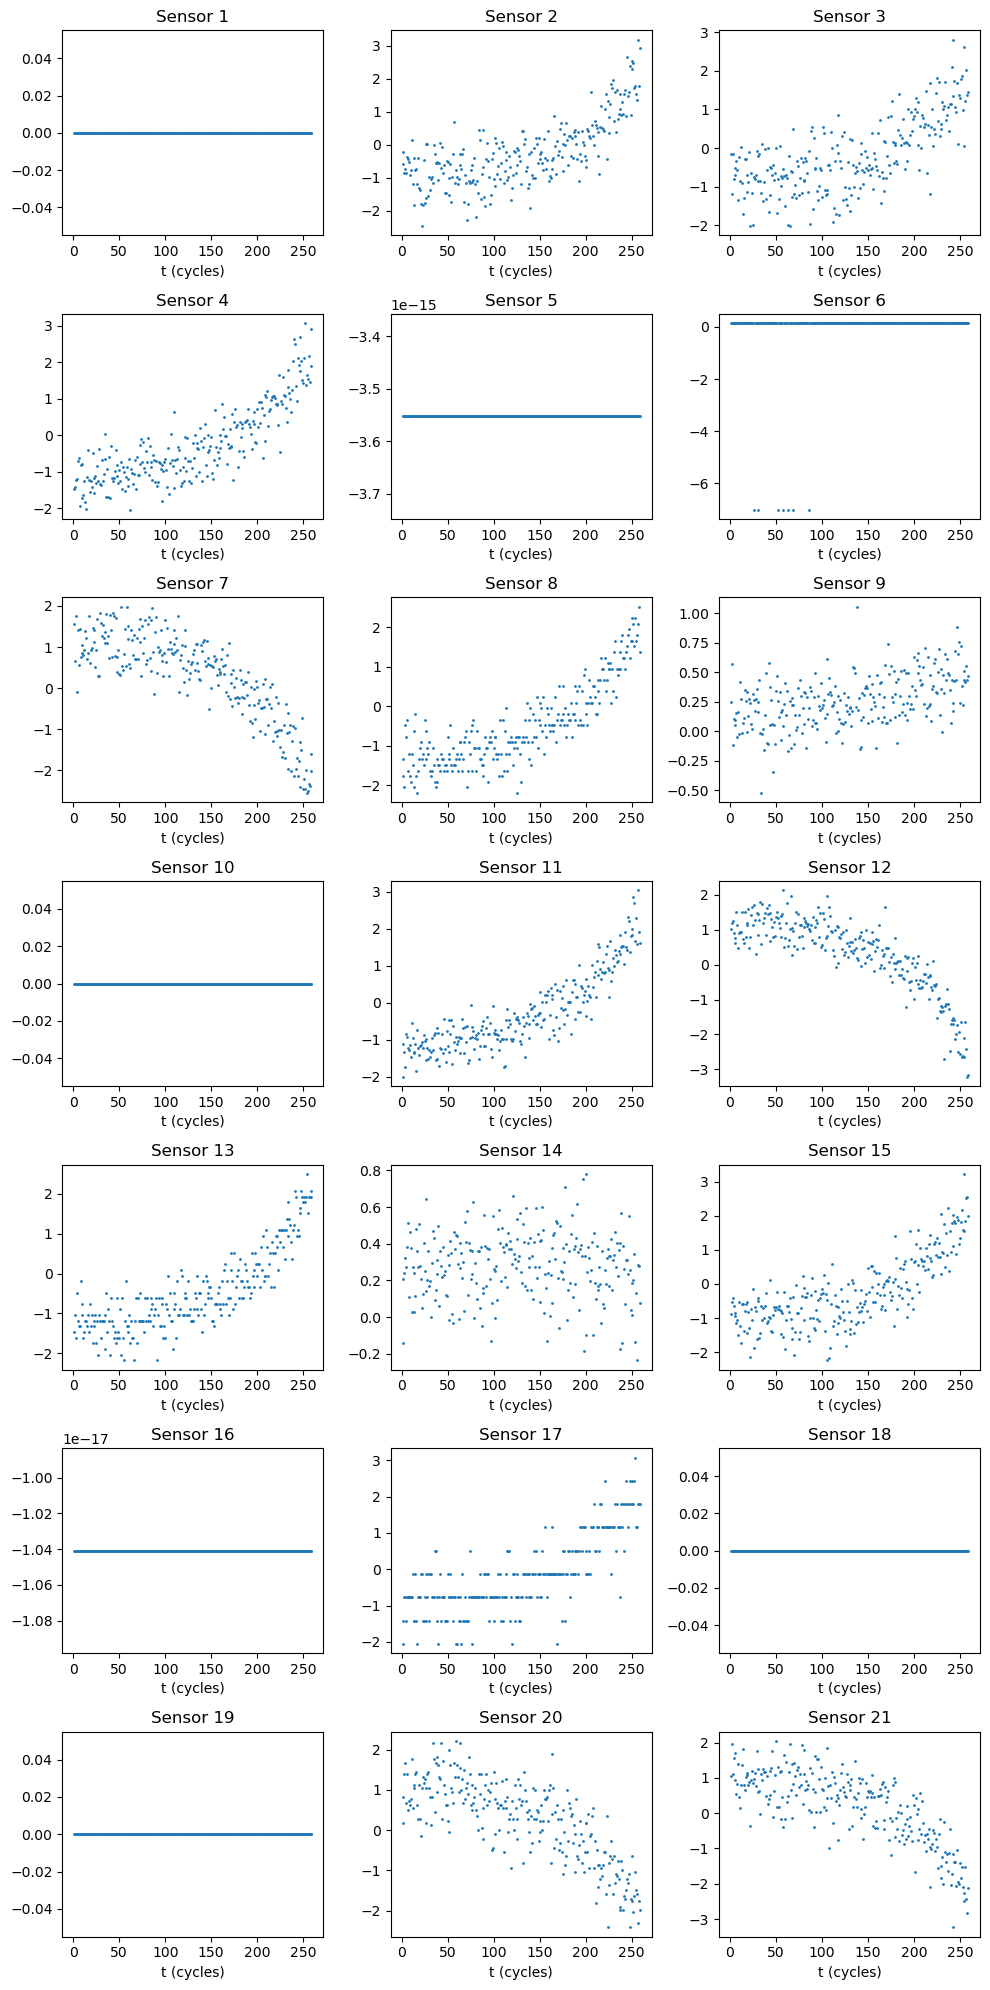

In [213]:
# Let's plot again  (Call split and Plot functions)
sensor_ids = range(1, 22)
#sensor_ids= [2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17,20, 21]
df_norm = pd.DataFrame(norm_x_train, columns=column_names[:-2])
df_norm

plot_all_sensors(df_norm, 7.0, sensor_ids)

Feature Extraction

In [214]:
def featureExtraction(data, desired_sensors):
  cols = desired_sensors+4
  desired_cols = np.append(np.array([0]), cols)
  data = data[:,[desired_cols]]
  return data

In [215]:
desired_sensors = np.array([2,3,4,7,8,9,11,12,13,14,15,17,20,21])
# desired_sensors = np.array([2,3,4,7,11,12,15,17])
Enorm_x_train = np.squeeze(featureExtraction(norm_x_train, desired_sensors))
Enorm_x_val = np.squeeze(featureExtraction(norm_x_val, desired_sensors))
Enorm_x_test = np.squeeze(featureExtraction(norm_x_test, desired_sensors))
print(Enorm_x_train.shape, Enorm_x_val.shape, Enorm_x_test.shape)

(14203, 15) (4241, 15) (37663, 15)


# Expanding \ Sliding Window (train, Val and test)

X-train, val, test prep

In [216]:
if max_len == T:
  x_train_list = slidingWindow(Enorm_x_train, T)
  x_val_list = slidingWindow(Enorm_x_val, T)
  x_test_list = testSlidingWindow(Enorm_x_test,T)
else:
  x_train_list = expandWindow(Enorm_x_train, min_len=5)
  x_val_list = expandWindow(Enorm_x_val, min_len=5)
  x_test_list = testExpandWindow(Enorm_x_test)
print(len(x_train_list), len(x_val_list), len(x_test_list))



13923 4161 300


 Y-train and val prep

In [217]:
y_train_ind = np.array([Enorm_x_train[:,0], y_train])
y_val_ind =  np.array([Enorm_x_val[:,0], y_val])
y_train_ind = np.transpose(y_train_ind)
y_val_ind = np.transpose(y_val_ind)
print(y_train_ind.shape, y_val_ind.shape)

(14203, 2) (4241, 2)


In [218]:
if max_len == T:
  min_len = T

y_train_list = yPrep(y_train_ind, min_len)
y_val_list = yPrep(y_val_ind, min_len)
print(len(y_train_list), len(y_val_list))

70 20


In [219]:
print(checkY(y_train_list), checkY(y_val_list))

13923 4161


In [220]:
y_trainf = np.concatenate(y_train_list)
y_valf = np.concatenate(y_val_list)
print(y_trainf.shape, y_valf.shape)

(13923,) (4161,)


Use Piecewise RUL values

In [221]:
y_trainf = np.where(y_trainf>125, 125,y_trainf)
y_valf = np.where(y_valf>125, 125,y_valf)
y_testf = np.where(y_test>125, 125,y_test)
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(13923,) (4161,) (300,)


Min-max normalization of y

In [222]:
y_trainf = y_trainf.reshape(-1,1)
y_valf = y_valf.reshape(-1,1)
y_testf = y_testf.reshape(-1,1)
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(13923, 1) (4161, 1) (300, 1)


In [223]:
y_scaler = MinMaxScaler()
y_scaler.fit(y_trainf)
y_trainf = y_scaler.transform(y_trainf)
y_valf = y_scaler.transform(y_valf)
y_testf = y_scaler.transform(y_testf)
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(13923, 1) (4161, 1) (300, 1)


In [224]:
y_trainf = y_trainf.squeeze()
y_valf = y_valf.squeeze()
y_testf = y_testf.squeeze()
print(y_trainf.shape, y_valf.shape, y_testf.shape)

print(y_testf)


(13923,) (4161,) (300,)
[0.168 1.    1.    0.912 0.976 1.    1.    1.    0.088 0.36  1.    0.264
 0.608 1.    1.    1.    1.    1.    0.44  0.24  0.016 0.328 1.    0.072
 0.616 1.    0.56  0.272 0.904 1.    0.856 1.    0.52  0.584 0.624 0.8
 0.872 0.904 0.216 1.    1.    0.992 0.864 0.848 0.568 0.464 0.08  0.512
 0.88  0.352 0.416 0.368 0.528 0.656 0.    0.032 0.48  0.04  0.256 1.
 0.992 1.    0.656 0.72  0.76  0.936 1.    0.104 1.    0.352 1.    1.
 1.    0.776 0.744 0.184 0.008 0.816 0.36  0.768 0.304 0.648 1.    0.896
 0.072 0.52  0.04  1.    1.    0.24  0.936 1.    0.6   0.664 0.704 0.88
 0.952 0.984 0.296 1.    1.    0.976 0.72  0.688 0.128 0.008 0.76  0.304
 0.712 0.032 0.56  0.04  0.336 0.272 1.    0.384 0.176 1.    0.448 0.728
 0.88  1.    0.544 0.608 0.648 0.824 0.896 0.928 0.24  1.    1.    0.92
 0.888 0.872 0.592 0.488 1.    0.536 0.904 0.376 0.44  0.392 0.552 0.68
 0.    0.032 0.504 0.04  0.28  1.    0.032 1.    1.    0.776 0.84  0.88
 1.    1.    0.224 1.    0.128 0.472 1.

Prepare dataset for use in pytorch

In [225]:
def collate_superv(data, max_len=max_len):
    """Build mini-batch tensors from a list of (X, y) tuples.
    Args:
        data: len(batch_size) list of tuples (X, y).
            - X: torch tensor of shape (seq_length, feat_dim); variable seq_length.
            - y: torch tensor of shape (1);
        max_len: global fixed sequence length. Used for architectures requiring fixed length input,
            where the batch length cannot vary dynamically. Longer sequences are clipped, shorter are padded with 0s
    Returns:
        X: (batch_size, padded_length, feat_dim) torch tensor of masked features (input)
        y: (batch_size,1)
        padding_masks: (batch_size, padded_length) boolean tensor, 1 means keep vector at this position, 0 ignore (padding)
    """

    batch_size = len(data)
    features, targets = zip(*data)

    # Stack and pad features and masks (convert 2D to 3D tensors, i.e. add batch dimension)
    lengths = [X.shape[0] for X in features]  # original sequence length for each time series
    if max_len is None:
        max_len = max(lengths)

    X = torch.zeros(batch_size, max_len, features[0].shape[-1])  # (batch_size, padded_length, feat_dim)

    for i in range(batch_size):
        end = min(lengths[i], max_len)
        X[i, :end, :] = features[i][:end, :]

    padding_masks = padding_mask(torch.tensor(lengths, dtype=torch.int16), max_len=max_len)  # (batch_size, padded_length) boolean tensor, "1" means keep
    # X = x.clone().detach().requires_grad_(True)
    X = X.clone().detach().requires_grad_(True).type('torch.FloatTensor')
    targets = torch.tensor(targets, dtype=torch.float).reshape(-1,1)
    return X, targets, padding_masks

In [226]:
train_dataset = supDataset(data_list=x_train_list, targets=y_trainf)
train_dataloader = DataLoader(dataset=train_dataset,
                    collate_fn=collate_superv,
                    batch_size=128,
                    shuffle=False,
                    # num_workers=2,
                    pin_memory=True)

In [227]:
val_dataset = supDataset(data_list=x_val_list, targets=y_valf)
val_dataloader = DataLoader(dataset=val_dataset,
                    collate_fn=collate_superv,
                    batch_size=128,
                    shuffle=False,
                    # num_workers=2,
                    pin_memory=True)

In [228]:
test_dataset = supDataset(data_list=x_test_list, targets=y_testf)
test_dataloader = DataLoader(dataset=test_dataset,
                    collate_fn=collate_superv,
                    batch_size=y_testf.shape[0],
                    shuffle=False,
                    # num_workers=2,
                    pin_memory=True)


# Training and Validation

Create device Object

In [229]:
# Check if MPS is available and set the device to MPS, else fall back to CUDA or CPU
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

mps


Train Function

In [230]:
from datetime import datetime
def train_eval(model, criterion, optimizer, train_dataloader, val_dataloader, patience, epochs, exp_no, transform):
  # Collect the train and test loss per epoch
  train_losses = []
  test_losses = []

  # early_stop_thresh = patience
  best_loss = float('inf')
  best_epoch = -1
  patience=patience

  # Loop over no of epochs
  for epoch in range(epochs):
    t0 = datetime.now()
    # Put model in training mode
    model.train()

    # accumulate loss per batch in one epoch
    train_epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    for batch in train_dataloader:

      X, targets, padding_masks = batch[0], batch[1], batch[2]

      # move data to GPU/ any available device
      X = X.to(device)
      targets = targets.to(device)
      padding_masks = padding_masks.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward Pass
      # regression: (batch_size, num_labels); classification: (batch_size, num_classes) of logits
      predictions = model(X, padding_masks, transform)
      loss = criterion(predictions, targets)  # (batch_size,) loss for each sample in the batch

      # Backward and optimize
      loss.backward()   # Compute Gradients (Back prop)
      optimizer.step()  # Update weights(GD/Adam)

      # Loss of this batch in this epoch
      train_epoch_loss += float(loss.item())*(X.shape[0])
      total_samples += X.shape[0]

    # Get average train loss
    train_epoch_loss = train_epoch_loss / total_samples

    # Make predictions with model at the end of each epoch
    test_epoch_loss = 0
    n_test = 0

    for batch in val_dataloader:
      X, targets, padding_masks = batch[0], batch[1], batch[2]
      # Move test data to device
      X = X.to(device)
      targets = targets.to(device)
      padding_masks = padding_masks.to(device)

      with torch.inference_mode():
        model.eval()
        predictions = model(X, padding_masks, transform)

      loss = criterion(predictions, targets)

      test_epoch_loss += float(loss.item()) *(X.shape[0])
      n_test += X.shape[0]

    test_epoch_loss = test_epoch_loss / n_test

    # Save losses
    train_losses.append(train_epoch_loss)
    test_losses.append(test_epoch_loss)

    dt = datetime.now() - t0
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_epoch_loss:.4f}, \
      Test Loss: {test_epoch_loss:.4f}, Duration: {dt}')

    # MODEL TRACKING/CHECKPOINTS FUNCTIONS
    if test_epoch_loss < best_loss:
      best_loss = test_epoch_loss
      best_epoch = epoch
      torch.save(model, f'best_model{dataset_id}.pt')
    if (epoch - best_epoch) > patience:
      print("Early stopped training at epoch %d" % (epoch+1))
      break  # terminate the training loop
    best_model = torch.load(f'best_model{dataset_id}.pt')
  return best_model, best_epoch, train_losses, test_losses

Score function

In [231]:
def score(errors):
  a1=10
  a2=13
  s1=0
  s2=0
  for err in errors:
    if err < 0:
      s1 += (np.exp(-1*(err/a1))) - 1
    if ((err > 0) or (err == 0)):
      s2 += (np.exp(err/a2)) - 1
  return [s1 , s2]

Put It All Together.

In [232]:
d_model = 18
transform = 'linear'

In [233]:
# Instantiate model
# Dropout 0.4 is the sweet spot
model = TSTransformerEncoderClassiregressor(feat_dim=14, max_len=max_len, d_model=d_model, n_heads=2, num_layers=2, dim_feedforward=10, num_classes=1,
                 dropout=0.2, pos_encoding='fixed', activation='gelu', norm='LayerNorm', freeze=False, transform=transform)

# Move model to the gpu if available ()
# Note: If you need to move a model to GPU via .cuda() ,
# Check if GPU is available
# please do so before constructing optimizers for it. Parameters of a model after .cuda() will be different objects with those before the call.
model.to(device)

# Instantiate loss and optimizer of choice
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.001)


/opt/anaconda3/envs/Maintenance/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [234]:
# # Call the train function
# best_model, best_epoch, train_losses, val_losses = train_eval(model, criterion, optimizer, train_dataloader,
#                                                               val_dataloader, patience=20, epochs=150, exp_no=1, transform=transform)

# # Plot Loss
# plot_loss_accuracy("Transformer", train_losses=train_losses, test_losses=val_losses)

# Validation

In [235]:
best_model = torch.load(f'trained_models/{dataset_id}_model_final.pt', map_location=device)

In [236]:
with torch.inference_mode():
  best_model.eval()

  for batch in val_dataloader:

    X, targets, padding_masks = batch[0], batch[1], batch[2]

    # move data to GPU/ any available device
    X = X.to(device)
    targets = targets.to(device)
    padding_masks = padding_masks.to(device)

    # Make predictions with best model
    y_pred = best_model(X, padding_masks, transform)

In [237]:
y_predb = torch.Tensor.cpu(y_pred).detach().numpy()
y_test = torch.Tensor.cpu(targets).detach().numpy()

# Inverse transform
y_predb = y_scaler.inverse_transform(y_predb)
y_test = y_scaler.inverse_transform(y_test)

# Get score and RMSE
RMSE = mean_squared_error(y_predb, y_test, squared=False)
MAE = mean_absolute_error(y_predb, y_test)
error = y_predb -  y_test
SCORES = score(error)
print(SCORES,RMSE, MAE)

[array([15.063161], dtype=float32), array([2.782728], dtype=float32)] 2.8780274 2.417235


/opt/anaconda3/envs/Maintenance/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Testing

In [238]:
best_model = torch.load(f'trained_models/{dataset_id}_model_final.pt', map_location=device)

with torch.inference_mode():
  best_model.eval()
  for batch in test_dataloader:

    X, targets, padding_masks = batch[0], batch[1], batch[2]
    print(X[0].shape, targets.shape, padding_masks.shape)

    # move data to GPU/ any available device
    X = X.to(device)
    targets = targets.to(device)
    padding_masks = padding_masks.to(device)
    print(X.shape, targets.shape, padding_masks.shape)

    # Make predictions with best model
    y_pred = best_model(X, padding_masks, transform)

torch.Size([362, 14]) torch.Size([300, 1]) torch.Size([300, 362])
torch.Size([300, 362, 14]) torch.Size([300, 1]) torch.Size([300, 362])


In [239]:
y_predb = torch.Tensor.cpu(y_pred).detach().numpy()
y_test = torch.Tensor.cpu(targets).detach().numpy()

# Inverse transform
y_predb = y_scaler.inverse_transform(y_predb)
y_test = y_scaler.inverse_transform(y_test)


# Get score and RMSE
RMSE = mean_squared_error(y_predb, y_test, squared=False)
MAE = mean_absolute_error(y_predb, y_test)
error = y_predb -  y_test
SCORES = score(error)
print(SCORES, RMSE, MAE)

[array([1295.602], dtype=float32), array([283.7239], dtype=float32)] 16.631855 13.266949


/opt/anaconda3/envs/Maintenance/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 0, 'True RUL')

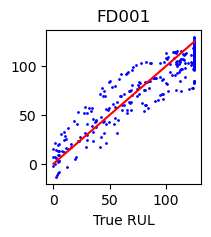

In [240]:
# Plot the results

ind = np.argsort(-y_test.squeeze(1))
plt.figure(figsize=(2,2));
plt.title(f'FD00{dataset_id}')
plt.scatter(y_test, y_predb, color='blue', s=1)
plt.plot([0,125],[0,125], color='red')
plt.xlabel('True RUL')
#plt.ylabel('Predicted RUL')

# Post Model Interpretability: LIME

In [241]:
print(f'Engines in this test set: {test_id}')

Engines in this test set: [31 61 66 53  6 89 67 15 94 40]


In [281]:
from lime import lime_tabular
import seaborn as sns


#Choose a sample to explain
engine_index = 5 # Choose an engine from the test set
sample = 11 # Between 1 and 30

print(f'You have chosen engine {test_id[engine_index]}')
print(f'This engine has the following RUL values: {y_test[engine_index*30:(engine_index+1)*30].flatten()}')

index = engine_index*30 + sample -1 # Index of the test set to be analyzed
print(f'RUL value of this sample: {y_test[index]}')

You have chosen engine 89
This engine has the following RUL values: [  4. 125. 125.  97. 105. 110. 125. 125.  28. 125.  16.  59. 125. 125.
 125. 112. 108.  38.   2.  24. 117.   8.  60. 111.  53.  96. 125. 125.
  11.  80.]
RUL value of this sample: [16.]


Below a wrapper is used to feed the input data to the model. Because LIME generates its own input data X, it does not supply the model with the needed padding data. The Padding mask is thus found by in abackwards way. For cycles where all sensors show 0, the padding mask is set to False. Importantly, when giving the LIME explainer the test data set to learn the shape of the data the whole dataset is padded to the dimension of the instance to be explained. If this was not done, Lime would also try to explain measurements that do not exist in the original instance.

In [257]:
# Define a wrapper for the forward method used by LIME
class ModelWrapper(nn.Module):
    def __init__(self, model, transform, max_len=max_len):
        super(ModelWrapper, self).__init__()  # Initialize the parent class
        self.model = model
        self.transform = transform
        self.max_len = max_len

    def forward(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).detach().to(device)
        X_tensor = torch.reshape(torch.tensor(X_tensor), (-1, self.max_len, 14))
        lengths = []
        for x in X_tensor.numpy():
            i = 0
            for timepoint in x:
                if np.all(timepoint == 0):
                    break
                i += 1
            lengths.append(i)

        self.padding_masks = padding_mask(torch.tensor(lengths, dtype=torch.int16), max_len=self.max_len)
        return self.model(X_tensor, self.padding_masks, self.transform)

In [258]:
if dataset_id == 1:
    max_len = 362
elif dataset_id == 3:
    max_len = 525

with torch.inference_mode():

    # Ensure device is set (assuming you're using GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the model
    best_model = torch.load(f'trained_models/{dataset_id}_model_final.pt', map_location=device)
    best_model.to(device)
    best_model.eval()

    # Instantiate the wrapped model
    wrapper = ModelWrapper(best_model, 'linear', max_len=max_len)
    
    # Get the test set
    for batch in test_dataloader:
        X, targets, padding_masks = batch[0], batch[1], batch[2]
        #print(X.shape, targets.shape, padding_masks.shape)
        break  # Just take the first batch for simplicity
        
    # Move data to GPU/ any available device
    X =  torch.tensor(X, dtype=torch.float32).to(device)
    targets = targets.to(device)
    padding_masks = padding_masks.to(device)

    # Make predictions to verify the model works
    true = y_scaler.inverse_transform(np.array(targets.detach().numpy()[index]).reshape(-1, 1))
    prediction = y_scaler.inverse_transform(wrapper(X[index]))
    print(f'The model predits; {prediction}')
    print(f'The true RUL is: {true}')
    
    # Convert padding_mask to match the batch dimension
    X_ref = X.detach().numpy()
    masks = padding_masks[index]
    batch_size = X.shape[0]
    padding_mask_expanded = np.expand_dims(masks, axis=0)
    padding_mask_expanded = np.repeat(padding_mask_expanded, batch_size, axis=0)

    # Apply the padding mask to X
    X_masked = X_ref.copy()  # Create a copy to avoid modifying the original data
    X_masked[~padding_mask_expanded] = 0

    # Convert to tensor and reshape
    X = torch.tensor(X_masked, dtype=torch.float32).to(device)
    X = torch.reshape(X, (X.shape[0], X.shape[1] * X.shape[2]))
    X = X.detach().numpy()

    # Create feature names
    feature_names = [f"time_{i}_sensor_{j}" for i in range(max_len) for j in range(14)]

    # Create the explainer
    explainer = lime_tabular.LimeTabularExplainer(X,feature_names=feature_names, mode='regression', verbose=True)

    # Explain the instance
    exp = explainer.explain_instance(X[index], wrapper, num_features=5068, num_samples=30000)

/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_32500/932309082.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X =  torch.tensor(X, dtype=torch.float32).to(device)
/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_32500/36208815.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).detach().to(device)
/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_32500/36208815.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.reshape(torch.tensor(X_t

The model predits; [[20.56050859]]
The true RUL is: [[16.]]


/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_32500/36208815.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.reshape(torch.tensor(X_tensor), (-1, self.max_len, 14))


Intercept 0.25255576768643856
Prediction_local [-0.03893972]
Right: 0.16448411


Plot a heatmap of the Lime values

[('time_178_sensor_9 <= 0.00', 0.014481922589881275), ('time_176_sensor_9 <= 0.00', 0.01188385756371567), ('time_182_sensor_9 <= 0.00', 0.011826502850695551), ('time_172_sensor_9 <= 0.00', 0.011631798761349035), ('time_180_sensor_5 > 0.00', -0.010187622867811242), ('time_165_sensor_9 <= 0.00', 0.00991247672995349), ('time_200_sensor_1 > 0.00', -0.009790329701664068), ('time_144_sensor_1 <= 0.00', 0.009737035579223039), ('time_69_sensor_1 <= -0.44', -0.009641957508464808), ('time_169_sensor_9 <= 0.00', 0.009491160044775055), ('time_189_sensor_9 > 0.00', -0.009172111424653245), ('time_170_sensor_1 > 0.00', -0.008937263135058889), ('time_181_sensor_5 > 0.00', -0.008918942930192639), ('time_195_sensor_1 > 0.00', -0.008773830113731219), ('time_184_sensor_9 <= 0.00', 0.00864489933731638), ('time_181_sensor_9 <= 0.00', 0.008437398602903993), ('time_193_sensor_1 <= 0.00', 0.008420912836677646), ('time_185_sensor_9 > 0.00', -0.008388252798316731), ('time_177_sensor_5 <= 0.00', 0.008266612983937

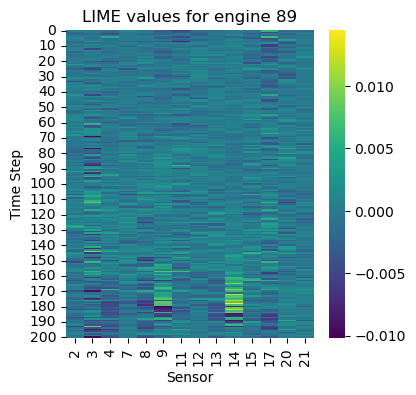

In [282]:
sensor_names = [2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]
max_cycle = x_test_list[index].shape[0]


lime_values = exp.as_list()
print(lime_values)
#exp.show_in_notebook(show_table=True)

# Extract and correctly parse the LIME values
lime_values = np.zeros(max_cycle * 14)
for feature, importance in exp.as_list():
    # Extract time step and sensor indices from the feature name
    parts = feature.split('_')
    time_step = int(parts[1])
    sensor = int(parts[3].split(' ')[0])
    index2 = time_step * 14 + sensor
    if time_step < max_cycle:
        lime_values[index2] = importance

# Reshape the LIME values to (362, 14)
lime_values_reshaped = lime_values.reshape(max_cycle, 14)

# Plot a heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(lime_values_reshaped, cmap="viridis", annot=False, xticklabels=sensor_names)
plt.title(f"LIME values for engine {test_id[engine_index]}")
plt.xlabel("Sensor")
plt.ylabel("Time Step")
plt.show()

Plot the time dependance of the lime values.

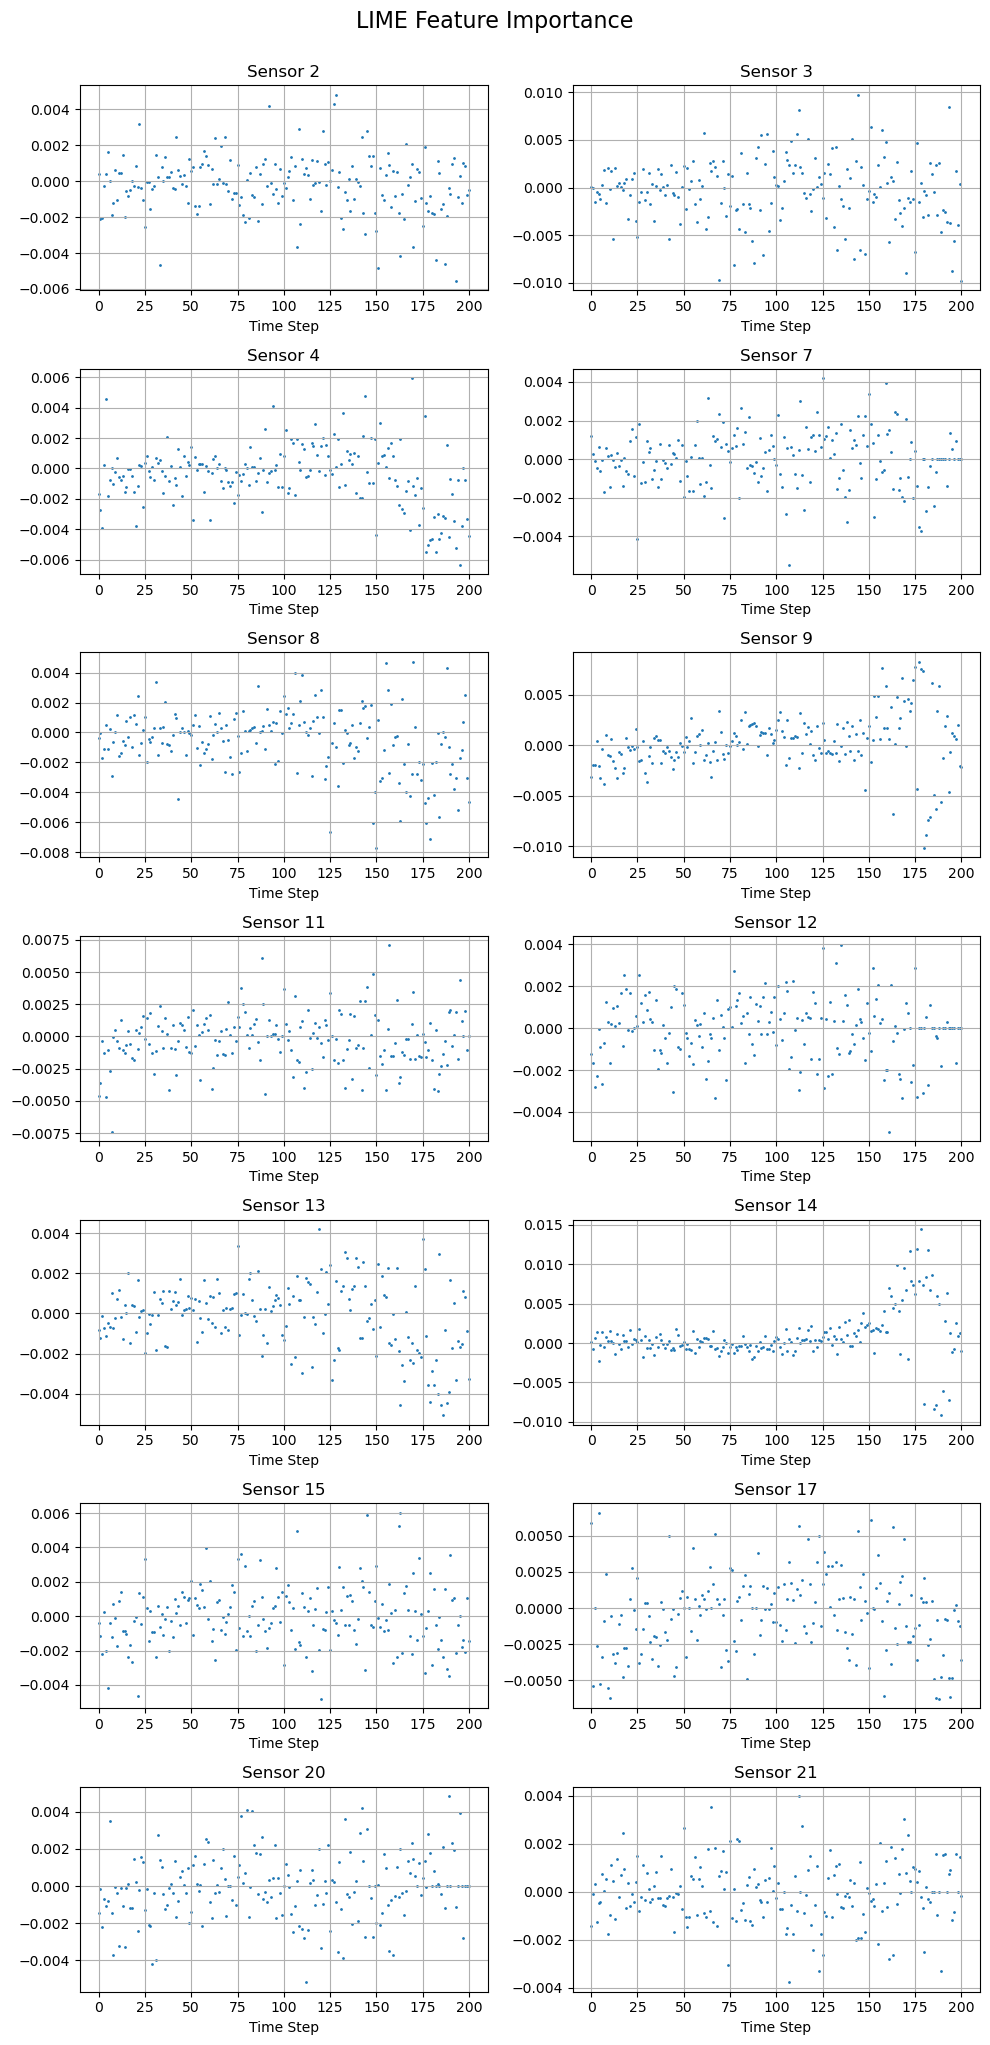

Sensor 2: Sum of LIME values = -0.04
Sensor 3: Sum of LIME values = -0.07
Sensor 4: Sum of LIME values = -0.10
Sensor 7: Sum of LIME values = 0.00
Sensor 8: Sum of LIME values = -0.12
Sensor 9: Sum of LIME values = 0.05
Sensor 11: Sum of LIME values = -0.05
Sensor 12: Sum of LIME values = -0.01
Sensor 13: Sum of LIME values = -0.03
Sensor 14: Sum of LIME values = 0.18
Sensor 15: Sum of LIME values = -0.00
Sensor 17: Sum of LIME values = -0.09
Sensor 20: Sum of LIME values = -0.02
Sensor 21: Sum of LIME values = -0.00


In [260]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_lime_importance(lime_values_reshaped, sensor_names, title='LIME Feature Importance'):
    # Number of subfigures, define the grid layout
    n_subfigures = len(sensor_names)
    rows = 7
    cols = math.ceil(n_subfigures / 7)

    time_steps = np.arange(lime_values_reshaped.shape[0])
    
    # Create the figure and axes objects
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 20))
    
    # Initialize an empty list to hold the sum of LIME values
    lime_sums = []

    # Loop over all possible subplots within the grid
    for i in range(n_subfigures):
        ax = axes[i // cols, i % cols]  # Locate the right subplot
        if i < n_subfigures:
            sensor_data = lime_values_reshaped[:, i]
            
            ax.scatter(time_steps, sensor_data, s=1)
            ax.set_xlabel('Time Step')
            ax.set_title(f"Sensor {sensor_names[i]}")
            ax.grid(True)

            # Calculate and store the sum of LIME values for the current sensor
            lime_sum = np.sum(sensor_data)
            lime_sums.append((sensor_names[i], lime_sum))
        else:
            ax.axis('off')  # Turn off axis for unused plots
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    # Show the plot
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()
    
    # Print the sum of LIME values for each sensor
    for sensor_name, lime_sum in lime_sums:
        print(f"Sensor {sensor_name}: Sum of LIME values = {lime_sum:.2f}")

# Assuming lime_values_reshaped is already defined and has shape (362, 14) or (max_cycle, 14)
sensor_names = [2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]  # List of sensor names to plot

plot_lime_importance(lime_values_reshaped, sensor_names)




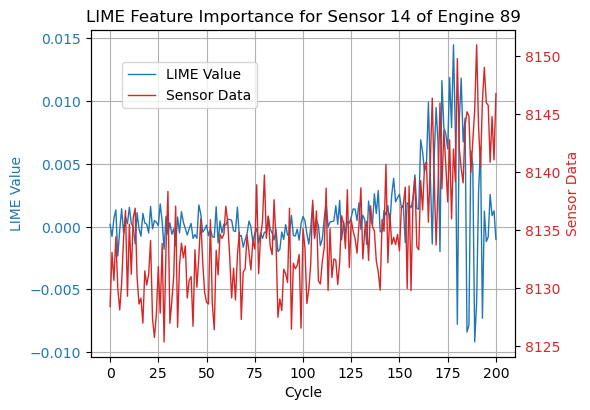

In [279]:
import matplotlib.pyplot as plt

# Assuming lime_values_reshaped is already defined and has shape (362, 14) or (max_cycle, 14)
# dict with sensor names and index for lime
sensor_names = {2: 0, 3: 1, 4: 2, 7: 3, 8: 4, 9: 5, 11: 6, 12: 7, 13: 8, 14: 9, 15: 10, 17: 11, 20: 12, 21: 13}
sensor = 14

engine = raw_train_df[raw_train_df['unit number'] == test_id[engine_index]]
sensor_data = engine[f'sensor measurement {sensor}'].values
# Extract the LIME values for the selected sensor
sensor_values = lime_values_reshaped[:, sensor_names[sensor]]
cycles = range(len(sensor_values))

#index min LIME value
min_lime = np.argmin(sensor_values)


# Plot the LIME values for the selected sensor
fig, ax1 = plt.subplots(figsize=(6, 4))

color = 'tab:blue'
ax1.set_xlabel('Cycle')
ax1.set_ylabel('LIME Value', color=color)
ax1.plot(cycles, sensor_values, color=color, label='LIME Value', linewidth=1)
#ax1.scatter(min_lime, sensor_values[min_lime], color='red', label='Min LIME Value', s=10)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Sensor Data', color=color)
ax2.plot(cycles, sensor_data[0:len(cycles)], color=color, label='Sensor Data', linewidth=1)
#ax2.scatter(min_lime, sensor_data[min_lime], color='red', label='Min LIME Value', s=10)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Adjust layout to prevent overlap

plt.title(f"LIME Feature Importance for Sensor {sensor} of Engine {test_id[engine_index]}")
fig.legend(loc="upper left", bbox_to_anchor=(0.2, 0.9))

plt.show()
